# Scraping Action to Gather Data on Hurricane Cost
In this notebook, I gather cost estimates for Hurricanes by scraping the cost estimates provided for a list of the top hurricanes by cost.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import requests
import re
import collections

I had originally intended to call the url of list of costliest atlantic hurricanes from Wikipedia and get the page html as text. Then convert the text to readable html using the lxml library.

However, there is a pandas function that makes this much more succint. I will leave the basic structure of the BeautifulSoup method here for posterity's sake, however it's much better to skip to the pandas Bit

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_costliest_Atlantic_hurricanes'
response = requests.get(url)

print(response.status_code, '\n')

soup = bs(response.text, "lxml")
print(soup.prettify())

# Isolate the table text
storm_table = soup.find_all('table')
soup.find('tr')

200 

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of costliest Atlantic hurricanes - Wikipedia
  </title>
  <script>
   document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );
  </script>
  <script>
   (window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"List_of_costliest_Atlantic_hurricanes","wgTitle":"List of costliest Atlantic hurricanes","wgCurRevisionId":862842880,"wgRevisionId":862842880,"wgArticleId":19082786,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Pages containing links to subscription-only content","CS1 Spanish-language sources (es)","Use mdy dates from August 2013","Atlantic hurricanes","Lists of tropical cyclones","Lists of superlatives"],"wgBreakFrames":false,"

<tr>
<th scope="col">Name
</th>
<th scope="col">Damage<br/>(Billions <a class="mw-redirect" href="/wiki/United_States_Dollar" title="United States Dollar">USD</a>)
</th>
<th scope="col">Season
</th>
<th scope="col">Storm <a class="mw-redirect" href="/wiki/Saffir%E2%80%93Simpson_hurricane_wind_scale" title="Saffir–Simpson hurricane wind scale">classification</a><br/>at peak intensity
</th>
<th class="unsortable" scope="col">Areas affected
</th>
<th class="unsortable" scope="col">References
</th></tr>

Now that we've isolated the table that we're looking for, I'll seek to get the text of each row. This was unintentional, but I found that if I searched for all `<tr>....</tr>` tags and asked for the text for each element, I more or less got what I wanted in string format.  

The code below does the above call and stores each element as a separate string. I'll reformat them accordingly later.

In [3]:
rows = []
for element in soup.find_all('tr'):
    
    #print(element.text)
    rows.append(element.text.split('\n'))

In [4]:
for row in rows[:3]:
    print(row)

['', 'Name', '', 'Damage(Billions USD)', '', 'Season', '', 'Storm classificationat peak intensity', '', 'Areas affected', '', 'References', '']
['', 'Katrina', '', '$125.0', '', '2005', '', 'Category\xa05 hurricane', '', '', 'Louisiana', 'The Bahamas', 'United States Gulf Coast', 'South Florida', 'Northeast', 'Eastern Canada', '', '', '[1][2]', '']
['', 'Harvey', '', '$125.0', '', '2017', '', 'Category\xa04 hurricane', '', '', 'Texas', 'Louisiana', 'South America', 'Central America', 'The Caribbean', 'Yucatan Peninsula', '', '', '[2][3]', '']


In [5]:
def cleanHeader(row):
    '''
    Drops empty strings from header row
    Accepts a row of data: list[str,str,...]
    Returns that row cleaned as needed: list[str,str,...]
    '''
    header = list(filter(None,row))
    header[3] = 'Storm class at peak intensity'
    return header

def cleanStormRow(row):
    '''
    Accepts a row of data: list[str,str,..]
    Returns that row cleaned as needed: list[str,str,...]
    '''
    data = list(filter(None,row))
    data[1] = data[1].replace('$','')
    data[3] = data[3].replace(r'\xa','')
    
    data[4] = ','.join(data[4:-1]) #Condensing affected areas into a single string
    del data[5:-1]
    return data

In [6]:
cleanHeader(rows[0])

['Name',
 'Damage(Billions USD)',
 'Season',
 'Storm class at peak intensity',
 'Areas affected',
 'References']

In [7]:
cleanStormRow(rows[1])

['Katrina',
 '125.0',
 '2005',
 'Category\xa05 hurricane',
 'Louisiana,The Bahamas,United States Gulf Coast,South Florida,Northeast,Eastern Canada',
 '[1][2]']

Credit to Alice Zhao (Metis Instructor) for the following tip. Instead of going through the html in the way I've been doing it above, I can use a useful Pandas method to read in the table.

In [8]:
df = pd.read_html(url, header=0)
print(len(df))
storms = df[0]
storms.info()

1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 6 columns):
Name                                     56 non-null object
Damage(Billions USD)                     56 non-null object
Season                                   56 non-null int64
Storm classificationat peak intensity    56 non-null object
Areas affected                           56 non-null object
References                               56 non-null object
dtypes: int64(1), object(5)
memory usage: 2.7+ KB


With the data imported, it's time to clean up the labels and convert the data to the appropriate type:
* Hurricane categories will be represented as integers from 1-5, with 0 meaning a tropical storm
* Make all column labels lowercase and rename to allow dot notation
* Convert damage numbers to numeric value.

In [9]:
def replaceCat(category):
    '''
    Input: str: string representing hurricane category
    Return: int:
                    0 if tropical storm
                    1-5 if categoried hurricane
    '''
    x = re.search(r'[0-6]+', category)
    return int(x.group()) if x else 0

In [10]:
# Rework category labels
storms.columns = [col.lower().strip() for col in storms.columns]

storms.rename({'storm classificationat peak intensity':'peak_category',
              'damage(billions usd)':'damage_busd',
              'areas affected': 'areas_affected'},
              axis = 'columns', inplace = True)

# Convert damage numbers to numberic
storms['damage_busd'] = storms['damage_busd']\
.apply(lambda x: float(re.sub(r'[$>]+', '',x)))

# Convert Category at peak intensity to number value representing category
storms['peak_category'] = storms['peak_category'].apply(
lambda x: replaceCat(x))

storms.head()

,name,damage_busd,season,peak_category,areas_affected,references
0,Katrina,125.0,2005,5,Louisiana The Bahamas United States Gulf Coast...,[1][2]
1,Harvey,125.0,2017,4,Texas Louisiana South America Central America ...,[2][3]
2,Maria,91.6,2017,5,Puerto Rico Lesser Antilles Greater Antilles C...,[2]
3,Sandy,68.7,2012,3,The Caribbean United States East Coast Eastern...,[2][4]
4,Irma,64.8,2017,5,Lesser Antilles Greater Antilles Caribbean Sea...,[2]


Text(0.5,1,'Costliest Atlantic Hurricanes in the US')

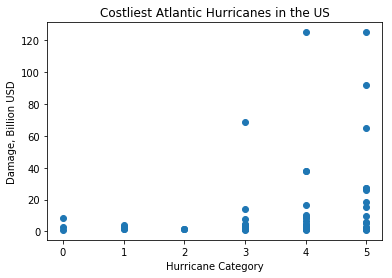

In [11]:
# Quick visualization of storm category vs damage
plt.scatter(storms.peak_category, storms.damage_busd)
plt.xlabel('Hurricane Category')
plt.ylabel('Damage, Billion USD')
plt.title('Costliest Atlantic Hurricanes in the US')

Moving forward, I'm going to pickle the data frame so that I can export it to my Jupyter Notebook going through the NOAA HURDAT2 data to match up these billion dollar storms.  

I'm also going to drop the references column before doing so, seeing as those numbers no longer point to any useful footnotes.

In [12]:
storms.drop(labels = ['references'], axis = 1, inplace = True)

In [13]:
storms.to_pickle('./billion_dollar_NA_storms.pkl')

I haven't had much success finding the database that the NOAA uses to store all of those costs. With that in mind, I think I may be able to scrape the needed costs from Wikipedia. Each year has a dedicated page for the North Atlantic Hurricanes. Of special interest is a table at the bottom of every year's article that lists the significant developments:
* Storm name
* Dates active
* Storm category at peak intensity
* Max 1 min. wind, mph(kph)
* Min. pressure, (mbar)
* Damage (USD)
* Deaths

If I can get this data for the last 20 years or so, I think that will be enough data points for now.

In [14]:
year = '2015'
url = 'https://en.wikipedia.org/wiki/'+year+'_Atlantic_hurricane_season'
tables = pd.read_html(url, header = 0)
tables[-5].iloc[:-2].head(15)

,Stormname,Dates active,Storm category at peak intensity,Max 1-minwindmph (km/h),Min.press.(mbar),Areas affected,Damage (USD),Deaths,Refs
0,Ana,May 8 – 11,Tropical storm,60 (95),998.0,Southeastern United States (South Carolina),Minimal,1 (1),NaN
1,Bill,June 16 – 18,Tropical storm,60 (95),997.0,"Central America, Yucatán Peninsula, Southern U...",$17.9 million,8 (1),NaN
2,Claudette,July 13 – 14,Tropical storm,50 (85),1003.0,"East Coast of the United States, Newfoundland",None,None,NaN
3,Danny,August 18 – 24,Category 3 hurricane,125 (205),960.0,"Lesser Antilles, Puerto Rico",Minor,None,NaN
4,Erika,August 25 – 29,Tropical storm,50 (85),1001.0,"Lesser Antilles (Dominica), Greater Antilles, ...",$511.4 million,31 (4),NaN
5,Fred,August 30 – September 6,Category 1 hurricane,85 (140),986.0,"West Africa, Cape Verde",$2.5 million,9,NaN
6,Grace,September 5 – 9,Tropical storm,60 (95),1000.0,None,None,None,NaN
7,Henri,September 8 – 11,Tropical storm,50 (85),1003.0,None,None,None,NaN
8,Nine,September 16 – 19,Tropical depression,35 (55),1006.0,None,None,None,NaN
9,Ida,September 18 – 27,Tropical storm,50 (85),1001.0,None,None,None,NaN


In [15]:
for idx, table in enumerate(tables):
    #print(idx)
    print(table.shape)
    if table.shape[1] == 9:
        print(table.columns)
    #print('\n\n\n\n')

(19, 2)
(16, 6)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(3, 2)
(0, 3)
(1, 7)
(14, 9)
Index(['Stormname', 'Dates active', 'Storm category at peak intensity',
       'Max 1-minwindmph (km/h)', 'Min.press.(mbar)', 'Areas affected',
       'Damage (USD)', 'Deaths', 'Refs'],
      dtype='object')
(0, 2)
(1, 1)
(7, 26)
(1, 12)


For 2015's page, there are 21 tables:
* The zero-th table is the summary stats table, top right.  
* The first table is the seasonal predictions table, 2nd on the right.  
* The 2nd table and following are the summary tables for each individual hurricane.  

* The 16th table is the one I'm looking for. $5^{th}$ from the end, and has 9 columns.
I found that the table position changes from (-5) to (-6) in some years, but I still may be able to use the number of columns to distinguish the desired table.

* The 17th table is empty.  
* The 18th table is a list to other pages for that decade.   
* The 19th table is a summary of that year's hurricanes.  
* The 20th is a table I can't identify. It may be citations.    

In [16]:
# For the table in question, we don't want the last two rows
tables[-5].iloc[:-2].head(15)

,Stormname,Dates active,Storm category at peak intensity,Max 1-minwindmph (km/h),Min.press.(mbar),Areas affected,Damage (USD),Deaths,Refs
0,Ana,May 8 – 11,Tropical storm,60 (95),998.0,Southeastern United States (South Carolina),Minimal,1 (1),NaN
1,Bill,June 16 – 18,Tropical storm,60 (95),997.0,"Central America, Yucatán Peninsula, Southern U...",$17.9 million,8 (1),NaN
2,Claudette,July 13 – 14,Tropical storm,50 (85),1003.0,"East Coast of the United States, Newfoundland",None,None,NaN
3,Danny,August 18 – 24,Category 3 hurricane,125 (205),960.0,"Lesser Antilles, Puerto Rico",Minor,None,NaN
4,Erika,August 25 – 29,Tropical storm,50 (85),1001.0,"Lesser Antilles (Dominica), Greater Antilles, ...",$511.4 million,31 (4),NaN
5,Fred,August 30 – September 6,Category 1 hurricane,85 (140),986.0,"West Africa, Cape Verde",$2.5 million,9,NaN
6,Grace,September 5 – 9,Tropical storm,60 (95),1000.0,None,None,None,NaN
7,Henri,September 8 – 11,Tropical storm,50 (85),1003.0,None,None,None,NaN
8,Nine,September 16 – 19,Tropical depression,35 (55),1006.0,None,None,None,NaN
9,Ida,September 18 – 27,Tropical storm,50 (85),1001.0,None,None,None,NaN


### Grabbing Storm Cost Data
I now need to iteratively grab table data across as many years as possible. I've selected from 2017 back until 1967, at which point the tables cease to exist.  

The code follows several steps to extract and format the desired data:
* Grab all tables on the webpage
* Identify the desired dataframe by number of columns
* Clean the dataframe:
 * standardize column names
 * make sensical type conversions
* store cleaned dataframe of that year's storms
* concatenate annual storm data  

I was able to achieve this iteratively by exploiting the similarity in the url and table structure. There were two different sets of column names, although thankfully in both versions they contained the same data. All methods here are unstable, to the extent that changes in the table structure on Wikipedia may cause errors here.

In [18]:
def clean_storm_data(df):
    """
    Accepts a pandas dataframe of data scraped from Wikipedia.
    Renames columns and converts data for consistency across different naming conventions
    
    Output columns:
    ['name', 'dates_active', 'max_storm_cat', 'max_sust_wind',
    'min_p', 'damage_USD', 'deaths']
    """
    
    df['name'] = df.iloc[:,0].apply(lambda x: x.strip().upper())
    df['dates_active'] = df.iloc[:,1].apply(lambda x: x.strip())
    
    # Need to resolve what to do for tropical depressions
    df['max_storm_cat'] = df.iloc[:,2].apply(replaceCat)
    df['max_sust_wind'] = df.iloc[:,3].apply(v_to_num)
    df['min_p'] = df.iloc[:,4].apply(p_to_num)
    
    df['areas_affected'] = df.iloc[:,5]
    df['damage_USD'] = df.iloc[:,6].apply(parse_damage)
    df['deaths'] = df.iloc[:,7].apply(parse_deaths)
    
    return df.iloc[:,9:]

def parse_damage(dmg_str):
    '''
    Accepts damage in a string format: '$1.2 Billion'
    Returns numeric value: 1200000000
    '''
    new_dmg = str(dmg_str).lower()
    magnitude = {'thousand': 3, 'million':6, 'billion': 9}
    
    # Distill value and order of magnitude
    value = re.search(r'[0-9]+', new_dmg)
    magntd = re.search(r'billion|million|thousand', new_dmg)
    
    # By looking at the data, I'm guessing that "minor" damage encompases
    # <= $100,000. For now, I'll set minor values to that
    
    if magntd:
        mult = 10**magnitude[magntd.group()]
    else:
        mult = 1
    
    # Compute and return actual cost
    if re.search(r'minor|minimal',new_dmg):
        return 100000.0
    elif value:
        return float(value.group())*mult
    else:
        return 0

def v_to_num(num_str):
    '''
    Accepts string of windspeeds in mph.
    Returns number value in knots.
    '''
    val = re.search(r'[0-9]+', str(num_str))
    
    # 1 kt is 0.868976 of a mph
    if val:
        return float(val.group())*0.868976
    else:
        return None
    
def p_to_num(num_str):
    '''
    Accepts string of pressures in hPa.
    Returns number value in mbar.
    '''
    val = re.search(r'[0-9]+', str(num_str))
    
    if val:
        return float(val.group())
    else:
        return None
    
def parse_deaths(num_str):
    '''
    Determines total deaths associated with any given storm.
    Accepts a string containing either 'None' or two numbers in parenthesis.
    Returns sum of equivalent numeric values.
    '''
    nums = re.findall(r'[0-9]+', str(num_str))
    return np.sum([int(value) for value in nums])

In [19]:
# Exploit consistency in url and table structure to go year by year and get all the data I can.
# The tables stop existing in 1967 so I'll collect up until that point.
good_tables = []
years = [str(year) for year in range(2017, 1967, -1)]

# Store column headers. On subsequent runs I'll code up a bit to clean the headers,
# however I need to what they are to set up the regular expression syntax.
column_headers = collections.defaultdict(list)

for year in years:
    url = 'https://en.wikipedia.org/wiki/'+year+'_Atlantic_hurricane_season'
    tables = pd.read_html(url, header = 0)
    
    
    # Find the table with 9 columns
    good_table = pd.DataFrame()
    for table in tables:
        if len(table.columns) == 9:
            good_table = table.iloc[:-2,:]
            # Add year column for matching
            good_table['year'] = [year]*good_table.shape[0]
            column_headers[tuple(good_table.columns)].append(year)
            # Send dataframe to be formatted consistently
            cleaned_df = clean_storm_data(good_table)
#             cleaned_df = good_table
            break
    
    # Store the good table if it exists, # print error if it doesn't
    if len(good_table) != 0:
        good_tables.append(cleaned_df)
    else:
        print('Error in year: '+year)

cost_data = pd.concat(good_tables).reset_index()
print(cost_data.shape)
print(cost_data.year.unique())

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

(818, 10)
['2017' '2016' '2015' '2014' '2013' '2012' '2011' '2010' '2009' '2008'
 '2007' '2006' '2005' '2004' '2003' '2002' '2001' '2000' '1999' '1998'
 '1997' '1996' '1995' '1994' '1993' '1992' '1991' '1990' '1989' '1988'
 '1987' '1986' '1985' '1984' '1983' '1982' '1981' '1980' '1979' '1978'
 '1977' '1976' '1975' '1974' '1973' '1972' '1971' '1970' '1969' '1968']


In [20]:
# Remove redundant index column
cost_data.drop(labels = 'index', axis = 1, inplace = True)
cost_data.head(10)

,year,name,dates_active,max_storm_cat,max_sust_wind,min_p,areas_affected,damage_USD,deaths
0,2017,ARLENE,April 19 – 21,0,43.44880,990.0,None,0.000000e+00,0.0
1,2017,BRET,June 19 – 20,0,43.44880,1007.0,"Guyana, Venezuela, Trinidad and Tobago, Windwa...",3.000000e+06,2.0
2,2017,CINDY,June 20 – 23,0,52.13856,991.0,"Honduras, Belize, Cayman Islands, Yucatán Peni...",2.500000e+07,2.0
3,2017,FOUR,July 5 – 7,0,26.06928,1009.0,None,0.000000e+00,0.0
4,2017,DON,July 17 – 18,0,43.44880,1005.0,"Windward Islands, Barbados, Trinidad and Tobago",0.000000e+00,0.0
5,2017,EMILY,July 30 – August 1,0,52.13856,1001.0,Florida,1.000000e+07,0.0
6,2017,FRANKLIN,August 7 – 10,1,73.86296,981.0,"Nicaragua, Honduras, Guatemala, Belize, Yucatá...",1.500000e+07,0.0
7,2017,GERT,August 12 – 17,2,95.58736,962.0,"Bermuda, East Coast of the United States, Atla...",0.000000e+00,2.0
8,2017,HARVEY,August 17 – September 1,4,112.96688,937.0,"Barbados, Suriname, Guyana, Windward Islands, ...",1.250000e+11,107.0
9,2017,IRMA,August 30 – September 12,5,156.41568,914.0,"Cape Verde, Leeward Islands (Barbuda, Saint Ma...",6.400000e+10,134.0


In [21]:
# Export cost data to pkl
cost_data.to_pickle('./hurricane_cost_data.pkl')